In [66]:
# Import the necessary libraries
import plotly
import plotly.subplots
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Trading parameters
INITIAL_CAPITAL = 50000
COMMISSION_PER_SHARE_TRADED = 0
MONTHLY_INSTALLMENTS = 4000
START_DATE = pd.Timestamp("2022-01-01")
END_DATE = pd.Timestamp("2024-06-17")

# Strategy parameters
EMA_FAST = 20
EMA_SLOW = 60
EMA_SUPERSLOW = 120
RSI_THRESHOLD = 70
SELL_PERCENTAGE = 0.01
TDFI_THRESHOLD = -100

# Import the data
df = pd.read_csv("data/BATS_SOXL.csv")
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df[(df["time"] >= START_DATE) & (df["time"] <= END_DATE)]

df[f"EMA{EMA_FAST}"] = df["close"].ewm(halflife=f"{EMA_FAST/2} days", times=df["time"]).mean()
df[f"EMA{EMA_SLOW}"] = df["close"].ewm(halflife=f"{EMA_SLOW/2} days", times=df["time"]).mean()
df[f"EMA{EMA_SUPERSLOW}"] = df["close"].ewm(halflife=f"{EMA_SUPERSLOW/2} days", times=df["time"]).mean()

In [67]:
# returns True if seq1 crosses under seq2 at the index
def cross_under(seq1, seq2, index):
    if index < 1: return False
    seq1 = np.array(seq1)
    seq2 = np.array(seq2)
    return seq1[index] < seq2[index] and seq1[index-1] >= seq2[index-1]

In [68]:
strategy_capital = np.zeros(df.shape[0])
strategy_capital[0] = INITIAL_CAPITAL
strategy_position_size = np.zeros(df.shape[0])
strategy_total_investment = np.zeros(df.shape[0])
strategy_total_investment[0] = INITIAL_CAPITAL

bah_position_size = np.zeros(df.shape[0])
bah_position_size[0] = INITIAL_CAPITAL/df.iloc[0]["close"]

annotations = np.full(df.shape[0], None)
buy_annotations = np.full(df.shape[0], None)
sell_annotations = np.full(df.shape[0], None)

remaining_buy_time = 0
buy_value = 0
last_buy_order_price = df.iloc[0]["close"]

for i_time in range(df.shape[0]-1):
    read_row = df.iloc[i_time]
    read_next_row = df.iloc[i_time+1]

    strategy_capital[i_time+1] = strategy_capital[i_time]
    strategy_total_investment[i_time+1] = strategy_total_investment[i_time]
    bah_position_size[i_time+1] = bah_position_size[i_time]
    strategy_position_size[i_time+1] = strategy_position_size[i_time]
    if i_time > 0 and read_row["time"].month != df.iloc[i_time-1]["time"].month:
        strategy_capital[i_time+1] += MONTHLY_INSTALLMENTS
        strategy_total_investment[i_time+1] += MONTHLY_INSTALLMENTS
        bah_position_size[i_time+1] += MONTHLY_INSTALLMENTS / read_next_row["open"]

    # sell whenever the RSI is above the threshold
    if read_row["RSI"] > RSI_THRESHOLD:
        shares_to_sell = int(strategy_position_size[i_time] * SELL_PERCENTAGE)
        strategy_capital[i_time+1] += shares_to_sell * (read_next_row["open"] - COMMISSION_PER_SHARE_TRADED)
        strategy_position_size[i_time+1] -= shares_to_sell
        annotations[i_time] = f"-{shares_to_sell}"
        sell_annotations[i_time] = f"-{shares_to_sell}"
        continue

    # if the SHA delta becomes positive while the TDFI is over a threshold, go all in
    # if cross_under(np.zeros(df.shape[0]), df["Smoothed HA (Open)"] - df["Smoothed HA (Close)"], i_time) and read_row["TDFI"] > TDFI_THRESHOLD:
    #     remaining_buy_time = 1
    #     buy_value = strategy_capital[i_time]
    # while EMA_FAST > EMA_SLOW, buy aggressively
    if read_row[f"EMA{EMA_FAST}"] > read_row[f"EMA{EMA_SLOW}"]: # elif if you allow SHA
        if cross_under(df["close"], df[f"EMA{EMA_FAST}"], i_time):
            remaining_buy_time = 5
            buy_value = 0.02 * strategy_capital[i_time]
        if cross_under(df["close"], df[f"EMA{EMA_SLOW}"], i_time) or cross_under(df["close"], df[f"EMA{EMA_SUPERSLOW}"], i_time):
            remaining_buy_time = 5
            buy_value = 0.10 * strategy_capital[i_time]
    # while EMA_SLOW < EMA_FAST, buy less aggressively
    else:
        if cross_under(df["close"], df[f"EMA{EMA_SLOW}"], i_time):
            remaining_buy_time = 5
            buy_value = 0.05 * strategy_capital[i_time]
        if np.abs(read_row["close"] - last_buy_order_price)/last_buy_order_price > 0.10:
            remaining_buy_time = 5
            buy_value = 0.02 * strategy_capital[i_time]
    
    # if the close > EMA_FAST, abort any buys
    if read_row["close"] > read_row[f"EMA{EMA_FAST}"]:
        remaining_buy_time = 0
        buy_value = 0
    
    # resolve the buying
    if remaining_buy_time > 0:
        shares_to_buy = np.max(int(buy_value / (read_next_row["open"] + COMMISSION_PER_SHARE_TRADED)),0)
        strategy_capital[i_time+1] -= shares_to_buy * (read_next_row["open"] + COMMISSION_PER_SHARE_TRADED)
        strategy_position_size[i_time+1] += shares_to_buy
        annotations[i_time] = f"+{shares_to_buy}"
        buy_annotations[i_time] = f"+{shares_to_buy}"
        
        last_buy_order_price = read_next_row["open"]
        remaining_buy_time -= 1

df["strategy_total_investment"] = strategy_total_investment
df["strategy_capital"] = strategy_capital
df["strategy_position_size"] = strategy_position_size
df["strategy_equity"] = strategy_capital + strategy_position_size * df["close"]
df["trade_annotations"] = annotations
df["bah_equity"] = bah_position_size * df["close"]

In [69]:
# Plot the graphs
fig = plotly.subplots.make_subplots(rows=2, cols=1, row_heights=[0.8, 0.2],  specs=[[{"secondary_y": True}],[{"secondary_y": True}]])
fig.update_yaxes(fixedrange=False)

# Plot price candlesticks
fig.add_trace(plotly.graph_objects.Candlestick(
    x=df["time"],
    open=df["open"],
    high=df["high"],
    low=df["low"],
    close=df["close"],
    name="Price",
))

# Buy/sell annotations
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df["high"],
    mode="text",
    text=buy_annotations,
    textposition="top center",
    textfont=dict(
        color="green",
        size=8
    ),
    showlegend=False,
))
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df["high"],
    mode="text",
    text=sell_annotations,
    textposition="top center",
    textfont=dict(
        color="red",
        size=8
    ),
    showlegend=False,
))

# Plot smoothed HA
fig.add_trace(plotly.graph_objects.Candlestick(
    x=df["time"],
    open=df["Smoothed HA (Open)"],
    high=df["Smoothed HA (High)"],
    low=df["Smoothed HA (Low)"],
    close=df["Smoothed HA (Close)"],
    increasing_line_color= "lightgray",
    decreasing_line_color= "pink",
    name="Smoothed HA"
))

# Plot EMA lines
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df[f"EMA{EMA_FAST}"],
    name=f"EMA {EMA_FAST}",
    line=dict(color="red", dash="dot")
))
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df[f"EMA{EMA_SLOW}"],
    name=f"EMA {EMA_SLOW}",
    line=dict(color="orange", dash="dot")
))
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df[f"EMA{EMA_SUPERSLOW}"],
    name=f"EMA {EMA_SUPERSLOW}",
    line=dict(color="gold", dash="dot")
))
# fig.add_trace(plotly.graph_objects.Scatter( # EMA 200
#     x=df["time"],
#     y=df["close"].ewm(halflife=f"{200/2} days", times=df["time"]).mean(),
#     name=f"EMA 200",
#     line=dict(color="green", dash="dot")
# ))

# Plot TDFI and RSI
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df["TDFI"],
    name="TDFI",
), row=2, col=1)
fig.add_trace(plotly.graph_objects.Scatter(
    x=df["time"],
    y=df["RSI"],
    name="RSI",
), row=2, col=1,
secondary_y=True)

fig.update_layout(xaxis_rangeslider_visible=False, autosize=False, width=1000, height=800)
fig.show()

STRATEGY RESULTS
Final equity as percentage of investment: 279.106%
Equivalent annual growth rate: +51.814%
Total investment: 166000.0
Total final equity: 463316.56665484

BUY AND HOLD COMPARISON
Final equity as percentage of investment: 243.346%
Equivalent annual growth rate: +43.579%
Total investment: 166000.0
Total final equity: 403955.09551805776


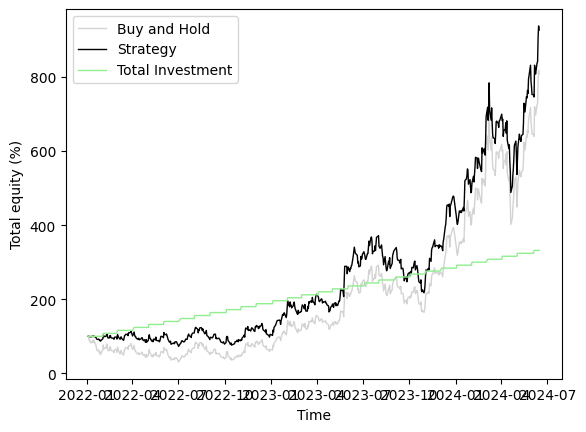

time,close,strategy_capital,strategy_position_size,strategy_equity,trade_annotations
2022-01-03 14:30:00,70.952739,50000.000000,0.000000,50000.000000,None
2022-01-04 14:30:00,69.939128,50000.000000,0.000000,50000.000000,+36
2022-01-05 14:30:00,62.991468,47534.705068,36.000000,49802.397902,+39
2022-01-06 14:30:00,64.497122,45074.971315,75.000000,49912.255474,+39
2022-01-07 14:30:00,58.789412,42577.238090,114.000000,49279.231079,+44
2022-01-10 14:30:00,59.045275,40094.423637,158.000000,49423.577095,+42
2022-01-11 14:30:00,62.282924,37652.133925,200.000000,50108.718785,None
2022-01-12 14:30:00,63.552398,37652.133925,200.000000,50362.613469,None
2022-01-13 14:30:00,59.242093,37652.133925,200.000000,49500.552453,None
2022-01-14 14:30:00,63.453989,37652.133925,200.000000,50342.931709,None


In [72]:
# Print results summary
print("STRATEGY RESULTS")
print("Final equity as percentage of investment: %.3f%%" % (df["strategy_equity"].iloc[-1]/df["strategy_total_investment"].iloc[-1]*100))
effann = (df["strategy_equity"].iloc[-1]/df["strategy_total_investment"].iloc[-1]) ** (1/((END_DATE - START_DATE).days/365.25)) * 100 -100
print("Equivalent annual growth rate: %s%.3f%%" % (
    "+" if effann >= 0 else "",
    effann
))
print("Total investment:", df["strategy_total_investment"].iloc[-1])
print("Total final equity:", df["strategy_equity"].iloc[-1])

print()
print("BUY AND HOLD COMPARISON")
print("Final equity as percentage of investment: %.3f%%" % (df["bah_equity"].iloc[-1]/df["strategy_total_investment"].iloc[-1]*100))
effann = (df["bah_equity"].iloc[-1]/df["strategy_total_investment"].iloc[-1]) ** (1/((END_DATE - START_DATE).days/365.25)) * 100 -100
print("Equivalent annual growth rate: %s%.3f%%" % (
    "+" if effann >= 0 else "",
    effann
))
print("Total investment:", df["strategy_total_investment"].iloc[-1])
print("Total final equity:", df["bah_equity"].iloc[-1])

# Plot results
plt.plot(df["time"], df["bah_equity"]/INITIAL_CAPITAL*100, label="Buy and Hold", color="lightgray", linewidth=1)
plt.plot(df["time"], df["strategy_equity"]/INITIAL_CAPITAL*100, label="Strategy", color="black", linewidth=1)
plt.plot(df["time"], df["strategy_total_investment"]/INITIAL_CAPITAL*100, label="Total Investment", color="lightgreen", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Total equity (%)")
plt.legend()
plt.show()

# Display action table
pd.set_option("display.max_rows", None)
df[["time", "close", "strategy_capital", "strategy_position_size", "strategy_equity", "trade_annotations"]].style.hide()